# Exercise 2

For this exercise, we developed an item-based Collaborative Filtering (CF) algorithm for movie recomendation on the MovieLens dataset. The implementation uses PySpark's DataFrame API.

## Imports

PySpark (version `>=3.4.0`) is the only non-standard library required.
Matplotlib is optional, but required to perform plots.

In [1]:
import pyspark.sql.functions as F
from pyspark import Broadcast
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import ArrayType, DoubleType, IntegerType
from typing import Iterable, Any, Tuple

try:
    import matplotlib.pyplot as plt
except ImportError:
    print('Matplotlib could not be imported, graphs won\'t be plotted.')
    plt = None

from pyspark.ml.clustering import BisectingKMeans

## Spark initialization

Spark is initialized, with as many worker threads as logical cores on the machine. We did not use a fixed value since the machines used for development had a different number of CPU cores.

In [2]:
spark = SparkSession.builder \
    .appName('ItemCF') \
    .config('spark.master', 'local[*]') \
    .getOrCreate()

23/05/04 17:35:32 WARN Utils: Your hostname, martinho-MS-7B86 resolves to a loopback address: 127.0.1.1; using 192.168.1.67 instead (on interface enp34s0)
23/05/04 17:35:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/04 17:35:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Prepare the data

The MovieLens 100K dataset is loaded for experimentation in the notebook.
Only the ratings in `u.data` are required for performing CF.
Both user and movie IDs as well as the ratings are converted into integers to occupy less memory.
The `timestamp` column is discarded, as rating time was not considered.

In [3]:
df = (spark.read
    .option('header', 'false')
    .option('sep', '\t')
    .csv('data/ml-100k/u.data')
)

df = (df.withColumnRenamed('_c0', 'user_id') 
    .withColumnRenamed('_c1', 'item_id')
    .withColumnRenamed('_c2', 'rating')
    .drop('_c3')
    .select(F.col('user_id').cast(IntegerType()), F.col('item_id').cast(IntegerType()), F.col('rating').cast(IntegerType()))
)

## Collaborative Filtering

For the item-based CF algorithm, the value of a predicted rating is:

$$
r_{xi} = b_{xi} + \frac{\sum_{j \in N(i;x)}{s_{ij} \cdot (r_{xi} - b_{xj})}}{\sum_{j \in N(i;x)}{s_{ij}}}
$$

where

$$
b_{xi} = \mu + b_x + b_i
$$

with:
- $\mu$ being the overall average movie rating
- $b_x$ being the rating deviation of user $x$
- $b_i$ being the rating deviation of movie/item $i$

The similarities $s_{ij}$ are calculated pairwise between movies when needed, and the ratings $r_{xj}$ are also queried when required.

On the other hand, the values for the baselines $\mu$, $b_x$ and $b_i$ can be calculated beforehand.

### Calculate baselines

Firstly, we pre-compute the necessary values for calculating the baselines when predicting ratings in the future. For the baselines we need the overall mean rating, mean rating of each user and mean rating of each movie.

To obtain the overall average, we simply aggregate the `ratings` column across all rows, performing an average.
For the user and item averages, we first perform grouping on the respective IDs and only then we aggregate the ratings of only within the rows of each group (i.e. user or item).

These results are collected into Python floats and dictionaries.
We also explicitly broadcast the `user_means` and `item_means` dictionaries beforehand, as they can take up some memory and will be necessary for prediciting ratings in multiple occasions.

In [4]:
def calculate_user_item_means(df: DataFrame) -> Tuple[Broadcast, Broadcast, float]:
    user_means = {
        row['user_id']:row['user_avg']
        for row in df.groupBy('user_id')
            .agg(F.avg('rating').alias('user_avg'))
            .collect()
    }
    item_means = {
        row['item_id']:row['item_avg']
        for row in df.groupBy('item_id')
            .agg(F.avg('rating').alias('item_avg'))
            .collect()
    }
    mu = df.agg(F.avg('rating').alias('overall_avg')).collect()[0]['overall_avg']

    user_means = spark.sparkContext.broadcast(user_means)
    item_means = spark.sparkContext.broadcast(item_means)

    return user_means, item_means, mu

### Clustering the movies

In order to obtain the $k$ items most similar to an item $i$, that were rated by $x$, we are required in theory to calculate the similarity between $i$ and all other items that rated $x$.

To reduce the complexity that this operation entails, we decided to use clustering on the items.
Basically, we cluster the entire ratings dataset beforehand, and when a rating on $i$ is required, we check to which cluster it belongs to and only evaluate its similarity with items on that cluster.

We decided to make use of Spark's builtin `BisectingKMeans` divisive clustering algorithm. 
This method was chosen since it allows setting a parameter `minDivisibleClusterSize` which can help in avoiding the creation of clusters with very few elements, which in turn can result in other clusters being very large.
This algorithm also tends to prioritize dividing large clusters before dividing smaller ones, and is performant.

The clustering is performed using the items' ratings by each user as features.
The `BisectingKMeans` algorithm requires as input a dataframe with rows as the objects and a column reserved for the features, which will be the list of ratings by each user on a given movie.

The `minDivisibleClusterSize` can be set to a minimum fixed number of neighbors (`>= 1`) or portion of the data (`< 1`).
For the default, we decided to set it to `1 / K` with `K` being the number of clusters.
This way, we ensure that each cluster needs to have at least a number of points equal to or greater than `1 / K` before being divided, which should decrease the probability that we find very small clusters.

In [5]:
def cluster_with_bisectingkmeans(matrix: DataFrame, minDivisibleClusterSize: float=None, k: int=50, seed: int=1) -> DataFrame:

    if minDivisibleClusterSize is None:
        minDivisibleClusterSize = 1 / k

    bkm = BisectingKMeans(featuresCol='ratings', minDivisibleClusterSize=minDivisibleClusterSize, predictionCol="cluster_id").setK(k).setSeed(seed)
    model = bkm.fit(matrix)

    return model.transform(matrix)


To create this dataframe, we can perform grouping on the items, collecting its ratings into a list.
However, we need to expand this list to include the ratings that were not performed, by inserting `0`s.
The lists of ratings will have a number of elements equal to the number of users in the dataset.
To do this, we associate the `user_id` to each rating when collecting the ratings into a list.
Afterwards, to make the sparse matrix, we use an UDF to fill on each index $m$ of the row the rating of user $m$ or `0` if they were not present in the list to begin with.

In [6]:
def build_item_ratings_sparse_matrix(dataset: DataFrame) -> DataFrame:
    user_number = df.select('user_id').distinct().count()

    @F.udf(returnType=ArrayType(IntegerType(),False))
    def utility_matrix_row(elems: Iterable[Any]):

        sparse_row = [0] * user_number
        
        for (user_id,rating) in elems:
            sparse_row[user_id-1] = rating

        return sparse_row

    return (dataset.groupBy('item_id')
        .agg(F.collect_list(F.array('user_id','rating')).alias('ratings'))
        .withColumn('ratings', utility_matrix_row(F.col('ratings')).cast(ArrayType(DoubleType(),False)))
    )

### Calculate prediction

With the clustering and utility matrix built, we can calculate the predicted ratings.

We developed a function `predict_ratings` that, taking a dataframe `test_set` containing the user-item pairs, builds a dataframe by adding a column `predicted_rating` to those pairs.
The dataframe is built purely on Spark DataFrame operations.
It receives the user-item pairs in `test_set`, the clustered utility matrix in `train_matrix_with_clusters`, and the user/item means and overall mean for the final formula.

Firstly, we perform a join with the utility matrix to obtain, for each item to predict the rating for in `test_set`, the cluster it belongs to and its ratings.
The join is `inner` in order to discard items that are not present in the utility matrix, as it doesn't make sense to make predictions on those in CF.

Then we add columns containing the user and item means, obtaining the value from the broadcasted variables.
Additionally, we transform the `ratings` column to remove the average item rating from each value, creating the column `ratings_pearson`.
The `_pearson` ratings are useful for calculating the similarity between items.

Another join with the utility matrix is performed, this time according to the cluster of each item in `test_set`.
In the utility matrix, we add a column containing the mean rating for each item (`other_item_mean`) and a column containing the `ratings` with the mean item rating subtracted from each value (`other_ratings_pearson`).
After this join, we have for every user-item pair in `test_set` many rows containing the ratings and item mean information of all items similar to the item in the user-item pair (in the same cluster).

A column `user_other_rating` is created containing the rating of the user, from the user-item pair, on each item of the cluster.
Since we only want to consider items that were rated by the user in the user-item pairs, then we filter the dataframe by removing the items that weren't rated by that user (`user_other_rating` equal to 0).
This has the side effect of also removing the item of the user-item pair itself since, in principle, it shouldn't have had a rating in the training data (that's the reason we are predicting).

Finally, we can calculate the predicted rating itself.
For this we first calculate the similarity between the items in the user-item pairs with each other item they are similar with and were rated by the user.
This uses the `_pearson` ratings that were built previously.

Then, the baseline estimates are computed and, finally, an aggregation is performed with each user-item pair (and other optional columns of `test_set`) as the keys, and the values as the summation of the results for each similar item as indicated by the previously shown formula.
The final aggregated column is the `predicted_rating`.
The `baseline` column is included in the grouping keys since it is used when calculating the `predicted_rating` even though it is not aggregated, as its value is the same for each similar item.

In [7]:
def predict_ratings(test_set: DataFrame, train_matrix_with_clusters: DataFrame, user_means: Broadcast, item_means: Broadcast, mu: float) -> DataFrame:
    """Predict user ratings on an item using item-based Collaborative Filtering. Function built with batch processing in mind.

    The supplied utility matrix should have an item for each row and the following columns:
    - `item_id` containing the item ID
    - `ratings` containing the respective row of the utility matrix
    - `cluster_id` containing the ID of the cluster the item belongs to

    Parameters
    ----------
    test_set : DataFrame
        Spark dataframe containing the user and item IDs in columns `user_id` and `item_id` respectively.
        May contain other columns, but they should not overlap with the internal columns
    train_matrix_with_clusters : DataFrame
        Spark dataframe representing the utility matrix
    user_means : Broadcast
        Spark-broadcasted Python dictionary, containing the average rating for each user
    item_means : Broadcast
        Spark-broadcasted Python dictionary, containing the average rating for each item
    mu : float
        Average overall rating
    """

    return (test_set
        .join(train_matrix_with_clusters, on='item_id', how='inner') # get cluster and ratings of test item
        # the join should be done first so that we remove items and users that were not trained on (never seen before)
        .withColumn('item_mean', F.udf(lambda x: item_means.value[x], returnType=DoubleType())('item_id'))
        .withColumn('user_mean', F.udf(lambda x: user_means.value[x], returnType=DoubleType())('user_id'))
        .withColumn('ratings_pearson', F.transform('ratings', lambda x: x - F.col('item_mean')))
        .join(train_matrix_with_clusters
            .withColumnsRenamed({
                'item_id': 'other_item_id',
                'ratings': 'other_ratings',
            })
            .withColumn('other_item_mean', F.udf(lambda x: item_means.value[x], returnType=DoubleType())('other_item_id'))
            .withColumn('other_ratings_pearson', F.transform('other_ratings', lambda x: x - F.col('other_item_mean'))),
            on='cluster_id',
            how='inner')
        .withColumn('user_other_rating', F.col('other_ratings')[F.col('user_id') - 1])
        .filter(F.col('user_other_rating') != 0) # should remove the test item since it never gave got a rating from the test user
        .withColumn('similarity',
            F.aggregate(
                F.zip_with('ratings_pearson', 'other_ratings_pearson', lambda x1, x2: x1 * x2),
                initialValue=F.lit(0.0),
                merge=lambda acc, x: acc + x
            )
            /
            (
                F.sqrt(F.aggregate(
                    F.transform('ratings_pearson', lambda x: x**2),
                    initialValue=F.lit(0.0),
                    merge=lambda acc, x: acc + x
                ))
                *
                F.sqrt(F.aggregate(
                    F.transform('other_ratings_pearson', lambda x: x**2),
                    initialValue=F.lit(0.0),
                    merge=lambda acc, x: acc + x
                ))
            )
        )
        .withColumn('baseline', -mu + F.col('user_mean') + F.col('item_mean')) # b_xi
        .withColumn('other_baseline', -mu + F.col('user_mean') + F.col('other_item_mean')) # b_xj
        .groupBy(*test_set.columns, 'baseline')
        .agg((F.col('baseline') + F.sum(F.col('similarity') * (F.col('user_other_rating') - F.col('other_baseline'))) / F.sum('similarity')).alias('predicted_rating'))
        .drop('baseline')
    )

## Testing

For testing we leave out 10% of the ratings for evaluation.
We perform a random split of the dataframe with a fixed seed, generating a dataframe for training and clustering and another with the test ratings to predict.

In [8]:
seed_random = 1
n_clusters = 50

train_set, test_set = df.randomSplit([9.0, 1.0], seed=seed_random)

user_means, item_means, mu = calculate_user_item_means(train_set)

Perform clustering on the training data only, and then associate the items in the testing data with their respective cluster.

In [9]:
train_matrix = build_item_ratings_sparse_matrix(train_set)
train_matrix_with_clusters = cluster_with_bisectingkmeans(train_matrix, minDivisibleClusterSize=1/n_clusters, k=n_clusters)

### Cluster analysis

Before proceeding, we can perform some cluster analysis on the data.
The plot below shows the number of elements on each cluster, after performing the clustering above.

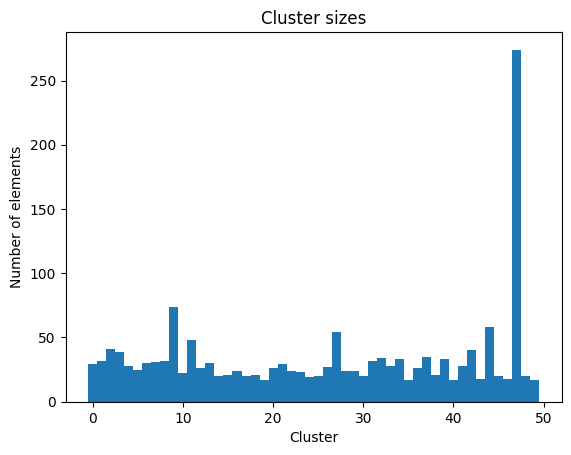

In [10]:
cluster_counts = [row['count']
    for row in (train_matrix_with_clusters
        .select('item_id', 'cluster_id')
        .distinct()
        .groupBy('cluster_id')
        .count()
    ).collect()
]

if plt is not None:
    plt.bar(list(range(n_clusters)), cluster_counts, width=1.0)
    plt.title('Cluster sizes')
    plt.xlabel('Cluster')
    plt.ylabel('Number of elements')

With the exception of 1 cluster, all clusters have a similar number of elements, which allows us to expect consistent performance when calculating similarities for any item.

If, for instance, we left the `minDivisibleClusterSize` parameter of the clustering algorithm with its default value (`1.0`), then many of the resulting clusters would have very few elements, and the cluster size would thus be much more skewed, with some clusters having almost no elements.

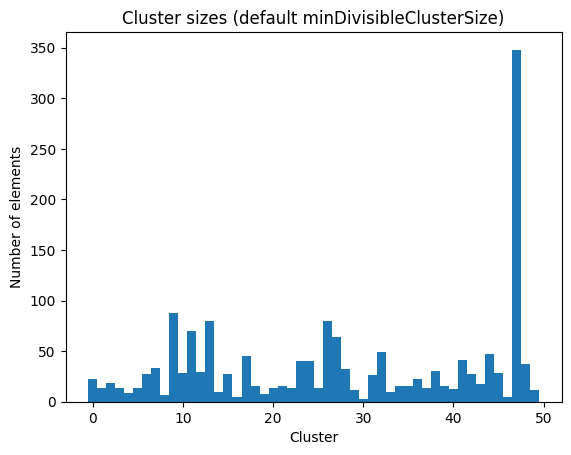

In [11]:
cluster_counts = [row['count']
    for row in (cluster_with_bisectingkmeans(train_matrix, minDivisibleClusterSize=1.0, k=n_clusters)
        .select('item_id', 'cluster_id')
        .distinct()
        .groupBy('cluster_id')
        .count()
    ).collect()
]

if plt is not None:
    plt.bar(list(range(n_clusters)), cluster_counts, width=1.0)
    plt.title('Cluster sizes (default minDivisibleClusterSize)')
    plt.xlabel('Cluster')
    plt.ylabel('Number of elements')

### Predictions

With the prediction function described previously, we can add the `predicted_rating` column to the `test_set`.
We also include the `rating` column renamed to `true_rating`, so that we have a pair of `true_rating` and `predicted_rating` columns ready for evaluation.

In [12]:
predictions = predict_ratings(test_set.withColumnRenamed('rating', 'true_rating'), train_matrix_with_clusters, user_means, item_means, mu)
predictions.show()

+-------+-------+-----------+------------------+
|user_id|item_id|true_rating|  predicted_rating|
+-------+-------+-----------+------------------+
|    886|     23|          4|3.3774950169833513|
|    882|     25|          2| 4.485426138352216|
|    637|     50|          4|3.4961996552313117|
|    213|     64|          5| 5.071685217733448|
|    711|     66|          4| 3.604034918930306|
|    571|     69|          2| 3.590501139686594|
|    682|     70|          4| 3.654812931614694|
|    894|     83|          4| 4.096264247296283|
|    374|     95|          4|3.9827569957412097|
|    308|     95|          4|3.8403190241222367|
|    742|    100|          5| 3.804908352276502|
|    267|    100|          5| 4.539557350220972|
|    672|    127|          4|3.0847568162985066|
|    738|    141|          3|3.2760568629370583|
|    555|    150|          4| 4.475181859829583|
|    633|    159|          4|3.1463729460970122|
|    142|    189|          4|3.7731246126877283|
|    661|    195|   

It's possible that some predictions can't be made since an item can be present in the test set but not in the training set, when doing the random splitting.
Below is the calculation of the portion of test ratings that were ignored when doing the predictions.

In [13]:
non_tested = (test_set
    .join(train_matrix_with_clusters, on='item_id', how='left')
    .filter(F.col('cluster_id').isNull())
).count()

tested_total = test_set.count()

In [14]:
print(f'Portion of user-item pairs that were not tested: {non_tested/tested_total:%}')

Portion of user-item pairs that were not tested: 0.138203%


### Evaluation

With the true and predicted ratings, we can calculate performance metrics.
Here we calculated the root-mean-square error (RMSE) using the formula:

$$
\sqrt{\frac{\sum_{xj}{(r_{xi} - r_{xi}^*)^2}}{\sum_{xj}{1}}}
$$

The denominator of the fraction can be calculated by simply counting the number of rows that were tested in the test set.
Therefore we have to exclude user-item pairs that could not be predicted.
For that, we simply perform the previous first inner join with `train_matrix_with_clusters`, which already excludes unpredictable user-item pairs.

In [15]:
total_tested = test_set.join(train_matrix_with_clusters, on='item_id', how='inner').count()

For the numerator, we utilize Spark on top of the `predictions` dataframe to compute the square error between the `true_rating` and the `predicted_rating` columns.
After performing a sum over all rows, the result is collected.

In [16]:
rmse = ((predictions
    .withColumn('square_error', (F.col('true_rating') - F.col('predicted_rating'))**2)
    .select('square_error')
    .groupBy()
    .sum('square_error')
    .collect()[0]['sum(square_error)']
    ) / (total_tested)) ** 0.5

And so, we have the RMSE calculated.
The performance is comparable to another collaborative filtering approach from 2015, which had an RMSE value of 0.945 (https://paperswithcode.com/sota/collaborative-filtering-on-movielens-100k).

In [17]:
print('RMSE:', rmse)

RMSE: 0.9469069462825471
